# K-means with tensor flow

## Tensors

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
conjunto_puntos = tf.zeros([2,2000])
print conjunto_puntos.get_shape()
vectors = tf.constant(value=0,shape=list(conjunto_puntos.get_shape()))
print vectors.get_shape()

(2, 2000)
(2, 2000)


In [3]:
print tf.expand_dims(vectors,0).get_shape()
print tf.expand_dims(vectors,1).get_shape()
print tf.expand_dims(vectors,2).get_shape()

(1, 2, 2000)
(2, 1, 2000)
(2, 2000, 1)


## Create the data

In [4]:
num_puntos = 2000
conjunto_puntos = []
for i in xrange(num_puntos):
    if np.random.random() > 0.5:
        conjunto_puntos.append([np.random.normal(0.0,0.9),np.random.normal(0.0,0.9)])
    else:
        conjunto_puntos.append([np.random.normal(3.0,0.5),np.random.normal(3.0,0.5)])

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
df = pd.DataFrame({"x":[v[0] for v in conjunto_puntos],
                   "y":[v[1] for v in conjunto_puntos]})

In [7]:
df.head()

,x,y
0,2.843996,2.974534
1,2.408048,2.965784
2,-0.292230,-0.304809
3,3.738219,2.582524
4,-1.332608,0.549956


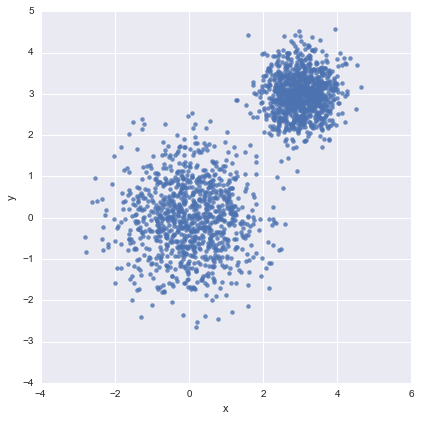

In [8]:
sns.lmplot("x","y",data=df,fit_reg=False,size=6)
plt.show()

## Initialize centroids at random points

In [9]:
# data
vectors = tf.constant(conjunto_puntos)
# number of clusters
k = 4
# centroids: take 'k' random centroids
intial_centroids = tf.slice(input_=tf.random_shuffle(vectors),begin=[0,0],size=[k,-1])
# the -1 in size=[k,-1] indicates that the size of the 2nd dimension in intial_centroids 
# is that of vectors 2nd dimension
print vectors.get_shape()
print intial_centroids.get_shape()
centroids = tf.Variable(intial_centroids)

(2000, 2)
(4, 2)


## Assign points to custers

we want to substract centroid components to each data point. For this, both tensors must have the same shape.

In [10]:
expanded_vectors = tf.expand_dims(vectors,0)
expanded_centroids = tf.expand_dims(centroids,1)
print expanded_vectors.get_shape()
print expanded_centroids.get_shape()

(1, 2000, 2)
(4, 1, 2)


now, we can substract both vectors; TF will deduce the missing dimensions in the expanded tensors

In [11]:
diff = tf.sub(expanded_vectors,expanded_centroids)
print diff
diff_squared = tf.square(diff)
print diff_squared
# add the squares of the difference along the two components (last dimension)
distance = tf.reduce_sum(diff_squared,reduction_indices=2)
print distance
# find the minimum distance from each point to a cluster 
# this returns the index of the cluster, rather than the distance (i.e. assigns points to clusters)
assignments = tf.argmin(distance,0)
print assignments

Tensor("Sub:0", shape=(4, 2000, 2), dtype=float32)
Tensor("Square:0", shape=(4, 2000, 2), dtype=float32)
Tensor("Sum:0", shape=(4, 2000), dtype=float32)
Tensor("ArgMin:0", shape=(2000,), dtype=int64)


## Calculate new centroids

In [12]:
def get_centroid(c,assignments,vectors):
    point_belongs_to_cluster = tf.equal(assignments,c) # shape = (2000,)
    #print point_belongs_to_cluster.get_shape()
    
    index_in_cluster = tf.where(point_belongs_to_cluster) # shape = (2000,)
    #print index_in_cluster.get_shape()

    reshape_points = tf.reshape(index_in_cluster,[1,-1])
    #print reshape_points.get_shape()

    points_with_index = tf.gather(vectors,reshape_points)
    #print points_with_index.get_shape()

    new_centroid = tf.reduce_mean(points_with_index,reduction_indices=1)
    #print new_centroid.get_shape()
    return new_centroid
    
means = tf.concat(concat_dim=0,values=[get_centroid(c,assignments,vectors) for c in xrange(k)])
update_centroids = tf.assign(centroids,means)

## Execute everything

In [13]:
init_op = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init_op)

In [14]:
for step in xrange(10):
    _,centroid_values,assignment_values = sess.run([update_centroids,centroids,assignments])

In [15]:
print centroid_values

[[  2.37188268e+00   2.84976029e+00]
 [ -9.38946381e-04  -4.59927469e-02]
 [  3.19745708e+00   3.44423866e+00]
 [  3.27270293e+00   2.56268740e+00]]


In [16]:
print assignment_values

[0 0 1 ..., 1 0 1]


## Plot results:

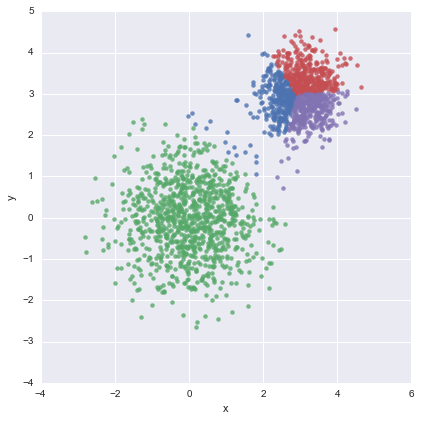

In [18]:
data = {"x":[],"y":[],"cluster":[]}
for i in xrange(len(assignment_values)):
    data["x"].append(conjunto_puntos[i][0])
    data["y"].append(conjunto_puntos[i][1])
    data["cluster"].append(assignment_values[i])
    
df = pd.DataFrame(data)
sns.lmplot("x","y",data=df,fit_reg=False,size=6,hue="cluster",legend=False)
plt.show()

## All at once

In [24]:
def create_data(num_puntos = 2000,plot=False):
    conjunto_puntos = []
    for i in xrange(num_puntos):
        if np.random.random() > 0.5:
            conjunto_puntos.append([np.random.normal(0.0,0.9),np.random.normal(0.0,0.9)])
        else:
            conjunto_puntos.append([np.random.normal(3.0,0.5),np.random.normal(3.0,0.5)])
            
    if plot:
        df = pd.DataFrame({"x":[v[0] for v in conjunto_puntos],
                           "y":[v[1] for v in conjunto_puntos]})
        sns.lmplot("x","y",data=df,fit_reg=False,size=6)
        plt.show()
        
    return conjunto_puntos

def get_centroid(c,assignments,vectors):
    point_belongs_to_cluster = tf.equal(assignments,c)     
    index_in_cluster = tf.where(point_belongs_to_cluster)
    reshape_points = tf.reshape(index_in_cluster,[1,-1])
    points_with_index = tf.gather(vectors,reshape_points)

    new_centroid = tf.reduce_mean(points_with_index,reduction_indices=1)
    return new_centroid
    
def customKMeans(num_puntos = 2000,num_clusters=3,plot=False):
    ##############
    # Generate data
    ##############
    conjunto_puntos = create_data(num_puntos)
    
    ##############
    # Initialize centroids
    ##############
    
    # load data into a tensor
    vectors = tf.constant(conjunto_puntos)
    # centroids: take 'k' random centroids
    intial_centroids = tf.slice(input_=tf.random_shuffle(vectors),begin=[0,0],size=[num_clusters,-1])
    # the -1 in size=[k,-1] indicates that the size of the 2nd dimension in intial_centroids 
    # is that of vectors 2nd dimension
    centroids = tf.Variable(intial_centroids)
    
    ##############
    # Assign points to clusters: calculate distance from each point to the centroid
    ##############
    expanded_vectors = tf.expand_dims(vectors,0)
    expanded_centroids = tf.expand_dims(centroids,1)

    diff_squared = tf.square(tf.sub(expanded_vectors,expanded_centroids))
    # add the squares of the difference along the two components "x" and "y" (last dimension)
    distance = tf.reduce_sum(diff_squared,reduction_indices=2)
    # find the minimum distance from each point to a cluster 
    # this returns the index of the cluster, rather than the distance (i.e. assigns points to clusters)
    assignments = tf.argmin(distance,0)
    
    ##############
    # Calculate new centroids
    ##############
    means = tf.concat(concat_dim=0,values=[get_centroid(c,assignments,vectors) for c in xrange(num_clusters)])
    update_centroids = tf.assign(centroids,means)

    ##############
    # Execute the graph
    ##############
    init_op = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init_op)
    for step in xrange(10):
        _,centroid_values,assignment_values = sess.run([update_centroids,centroids,assignments])

    print "Centroids: %s" % centroid_values

    ##############
    # Plot result
    ##############
    if plot:
        data = {"x":[],"y":[],"cluster":[]}
        for i in xrange(len(assignment_values)):
            data["x"].append(conjunto_puntos[i][0])
            data["y"].append(conjunto_puntos[i][1])
            data["cluster"].append(assignment_values[i])

        df = pd.DataFrame(data)
        sns.lmplot("x","y",data=df,fit_reg=False,size=6,hue="cluster",legend=False)
        plt.show()

Centroids: [[ 0.26500627  0.63446712]
 [-0.29754367 -0.66949779]
 [ 3.15470195  3.41245937]
 [ 2.8648808   2.65764141]]


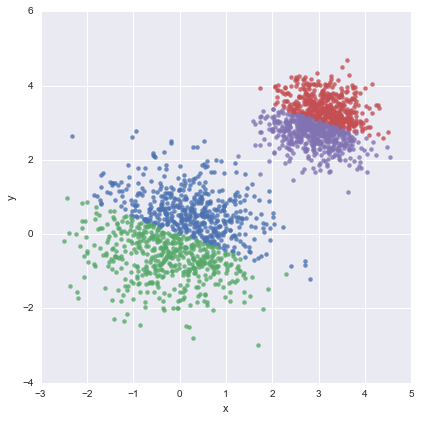

In [25]:
customKMeans(2000,num_clusters=4,plot=True)

Centroids: [[ 3.00043535  3.00775862]
 [-0.02330305 -0.87272233]
 [-0.98705149  0.39599076]
 [ 0.65510321  0.57441002]]


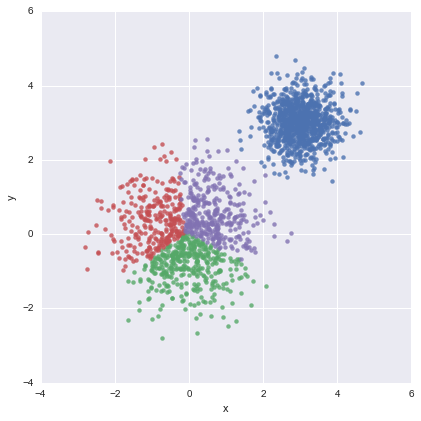

In [26]:
customKMeans(2000,num_clusters=4,plot=True)

Centroids: [[-0.05644553 -0.06823984]
 [ 3.06893468  3.49985814]
 [ 3.43945074  2.67683482]
 [ 2.42783976  2.71865606]]


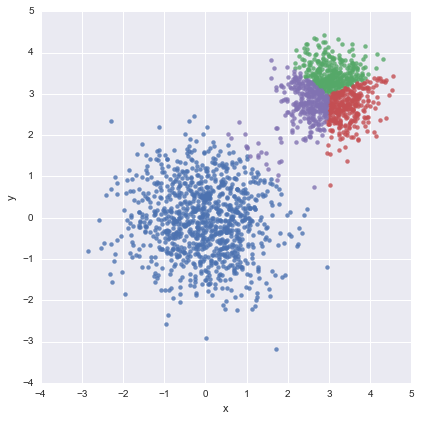

In [27]:
customKMeans(2000,num_clusters=4,plot=True)

Centroids: [[ 2.95958018  3.45726562]
 [ 2.31497598  2.61972284]
 [-0.06764618 -0.08817837]
 [ 3.36627889  2.67037439]]


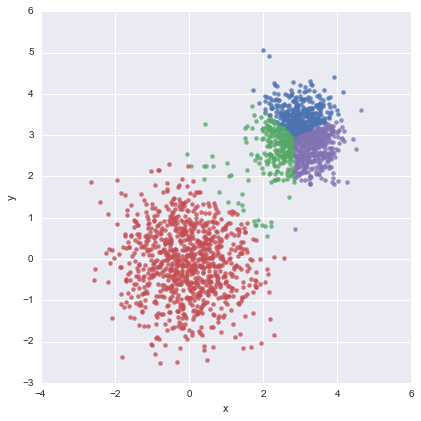

In [28]:
customKMeans(2000,num_clusters=4,plot=True)